# Import packages and dataframes

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from anndata import AnnData, read_h5ad
import singlecellmultiomics.bamProcessing.bamToRNACounts
import scanpy.external as sce
import scipy

#scv.settings.verbosity = 3 # show errors(0), warnings(1), info(2), hints(3)
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

#scv.settings.presenter_view = True  # set max width size for presenter view
#scv.set_figure_params('scvelo')  # for beautified visualization
sc.set_figure_params(dpi=100, color_map = 'viridis')

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.6.0 pandas==1.2.0 scikit-learn==0.24.0 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
pathToData = '/Users/m.blotenburg/Documents/Projects/TCHIC/data/rep2/20210215_OUD5651_K27me3K4me3_day5_20201023fixed/'

Import and check adata transcriptome file

In [3]:
adata = sc.read(pathToData + 'dataframes/20210224_TCHIC_rep2_Scanpy.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 4396 × 27312
    obs: 'n_counts', 'n_genes', 'percent_mito', 'batch', 'day', 'replicates', 'mark', 'umap_density_mark', 'leiden', 'louvain', 'celltype', 'cellnames', 'bc', 'cellname'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'celltype_colors', 'day_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'mark_colors', 'neighbors', 'pca', 'rank_genes_groups', 'replicates_colors', 'umap', 'umap_density_mark_params'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [5]:
adata.obs.head(2)

,n_counts,n_genes,percent_mito,batch,day,replicates,mark,umap_density_mark,leiden,louvain,celltype,cellnames,bc,cellname
PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1:ATCGTGCA,4157.0,2238,0.205485,PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1,Gastd5,rep2,H3K27me3,0.965432,4,4,Somite,PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1:ATCGTGCA,268,PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1_268
PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1:ACGAACAC,11456.0,4306,0.134695,PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1,Gastd5,rep2,H3K27me3,0.308473,3,3,Somite,PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1:ACGAACAC,368,PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1_368


In [6]:
adata.var.head(2)

,Accession,Chromosome,End,Start,Strand,n_cells,highly_variable,means,dispersions,dispersions_norm,mean,std
Xkr4,ENSMUSG00000051951,1,3671498,3205901,-,160,False,0.003954,-1.681012,0.604780,1.509480e-11,0.024000
Sox17,ENSMUSG00000025902,1,4497354,4490931,-,402,True,0.016667,-1.187675,1.588678,5.667170e-12,0.058612


Import and check chic TSS files

In [7]:
TSS_table_k4 = pd.read_csv(pathToData + 'k4me3/chic/K4me3_TSS_count_table.csv', index_col=(0,1,2,3), 
                        header= 0, low_memory=False)
TSS_table_k4 = TSS_table_k4.iloc[1:]
TSS_table_k4.index.names = ['reference_name','start','end', 'bname']
TSS_table_k4.head(2)

PZ-MB-TChIC-Gastd5-rep2-H3K4me3-3_322  \
reference_name start     end       bname                                            
1              195254848 195264848 Gm38046                                    1.0   
               187078884 187088884 Gm43497                                    1.0   

                                            PZ-MB-TChIC-Gastd5-rep2-H3K4me3-1_222  \
reference_name start     end       bname                                            
1              195254848 195264848 Gm38046                                    NaN   
               187078884 187088884 Gm43497                                    NaN   

                                            PZ-MB-TChIC-Gastd5-rep2-H3K4me3-6_202  \
reference_name start     end       bname                                            
1              195254848 195264848 Gm38046                                    NaN   
               187078884 187088884 Gm43497                                    NaN   

                                            PZ-MB-TChIC-Gastd5-rep2-H3K4me3-6_78  \
reference_name start     end       bname                                           
1              195254848 195264848 Gm38046                                   NaN   
               187078884 187088884 Gm43497                                   NaN   

                                            PZ-MB-TChIC-Gastd5-rep2-H3K4me3-2_233  \
reference_name start     end       bname                                            
1              195254848 195264848 Gm38046                                    NaN   
               187078884 187088884 Gm43497                                    NaN   

                                            PZ-MB-TChIC-Gastd5-rep2-H3K4me3-2_364  \
reference_name start     end       bname                                            
1              195254848 195264848 Gm38046                                    NaN   
               187078884 187088884 Gm43497                                    NaN   

                                            PZ-MB-TChIC-Gastd5-rep2-H3K4me3-1_299  \
reference_name start     end       bname                                            
1              195254848 195264848 Gm38046                                    NaN   
               187078884 187088884 Gm43497                                    NaN   

                                            PZ-MB-TChIC-Gastd5-rep2-H3K4me3-3_51  \
reference_name start     end       bname                                           
1              195254848 195264848 Gm38046                                   NaN   
               187078884 187088884 Gm43497                                   NaN   

                                            PZ-MB-TChIC-Gastd5-rep2-H3K4me3-3_228  \
reference_name start     end       bname                                            
1              195254848 195264848 Gm38046                                    NaN   
               187078884 187088884 Gm43497                                    NaN   

                                            PZ-MB-TChIC-Gastd5-rep2-H3K4me3-6_20  \
reference_name start     end       bname                                           
1              195254848 195264848 Gm38046                                   NaN   
               187078884 187088884 Gm43497                                   NaN   

                                            ...  \
reference_name start     end       bname    ...   
1              195254848 195264848 Gm38046  ...   
               187078884 187088884 Gm43497  ...   

                                            PZ-MB-TChIC-Gastd5-rep2-H3K4me3-1_244  \
reference_name start     end       bname                                            
1              195254848 195264848 Gm38046                                    NaN   
               187078884 187088884 Gm43497                                    NaN   

                                            PZ-MB-TChIC-Gastd5-rep2-H3K4me3-5_56  \
reference_name s

In [8]:
TSS_table_k27 = pd.read_csv(pathToData + 'k27me3/chic/K27me3_TSS_count_table.csv', index_col=(0,1,2,3), 
                        header= 0, low_memory=False)
TSS_table_k27 = TSS_table_k27.iloc[1:]
TSS_table_k27.index.names = ['reference_name','start','end', 'bname']
TSS_table_k27.head(2)

PZ-MB-TChIC-Gastd5-rep2-H3K27me3-4_266  \
reference_name start     end       bname                                             
1              195254848 195264848 Gm38046                                     1.0   
               195236007 195246007 Gm27940                                     1.0   

                                            PZ-MB-TChIC-Gastd5-rep2-H3K27me3-4_306  \
reference_name start     end       bname                                             
1              195254848 195264848 Gm38046                                     1.0   
               195236007 195246007 Gm27940                                     2.0   

                                            PZ-MB-TChIC-Gastd5-rep2-H3K27me3-6_237  \
reference_name start     end       bname                                             
1              195254848 195264848 Gm38046                                     1.0   
               195236007 195246007 Gm27940                                     NaN   

                                            PZ-MB-TChIC-Gastd5-rep2-H3K27me3-5_126  \
reference_name start     end       bname                                             
1              195254848 195264848 Gm38046                                     1.0   
               195236007 195246007 Gm27940                                     NaN   

                                            PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1_292  \
reference_name start     end       bname                                             
1              195254848 195264848 Gm38046                                     1.0   
               195236007 195246007 Gm27940                                     NaN   

                                            PZ-MB-TChIC-Gastd5-rep2-H3K27me3-6_273  \
reference_name start     end       bname                                             
1              195254848 195264848 Gm38046                                     1.0   
               195236007 195246007 Gm27940                                     NaN   

                                            PZ-MB-TChIC-Gastd5-rep2-H3K27me3-5_174  \
reference_name start     end       bname                                             
1              195254848 195264848 Gm38046                                     2.0   
               195236007 195246007 Gm27940                                     NaN   

                                            PZ-MB-TChIC-Gastd5-rep2-H3K27me3-3_104  \
reference_name start     end       bname                                             
1              195254848 195264848 Gm38046                                     1.0   
               195236007 195246007 Gm27940                                     NaN   

                                            PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1_263  \
reference_name start     end       bname                                             
1              195254848 195264848 Gm38046                                     2.0   
               195236007 195246007 Gm27940                                     NaN   

                                            PZ-MB-TChIC-Gastd5-rep2-H3K27me3-4_382  \
reference_name start     end       bname                                             
1              195254848 195264848 Gm38046                                     1.0   
               195236007 195246007 Gm27940                                     NaN   

                                            ...  \
reference_name start     end       bname    ...   
1              195254848 195264848 Gm38046  ...   
               195236007 195246007 Gm27940  ...   

                                            PZ-MB-TChIC-Gastd5-rep2-H3K27me3-3_161  \
reference_name start     end       bname                                             
1              195254848 195264848 Gm38046                                     NaN   
               195236007 195246007 Gm27940                                     NaN   

                                            

In [9]:
TSS_k27 = TSS_table_k27.droplevel(['start', 'end', 'reference_name'], axis=0)
TSS_k27.T.head(2)

bname,Gm38046,Gm27940,Gm37887,Cr2,Gm37132,Gm37027,Gm32250,Gm16897,Gm19777,Camk1g,...,Gm47631,Gm4312,Dynlt1c,Gm48154,BB287469,Gm28986,Gm27341,Scgb2b9-ps,Gm23713,Gm24539
PZ-MB-TChIC-Gastd5-rep2-H3K27me3-4_266,1.0,1.0,2.0,1.0,2.0,2.0,1.0,3.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PZ-MB-TChIC-Gastd5-rep2-H3K27me3-4_306,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
TSS_k4 = TSS_table_k4.droplevel(['start', 'end', 'reference_name'], axis=0)
TSS_k4.T.head(2)

bname,Gm38046,Gm43497,Gm17968,Gm16539,Wdr26,Nespas,Ncstn,Klhdc9,Gm20045,Uhmk1,...,Gm48040,Olfr937,Amelx,Gm24062,Gm14805,Pramel5,Gm23181,Gm27156,Prdx6-ps2,Gm4760
PZ-MB-TChIC-Gastd5-rep2-H3K4me3-3_322,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PZ-MB-TChIC-Gastd5-rep2-H3K4me3-1_222,NaN,NaN,1.0,NaN,1.0,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Check shapes of dataframes

In [11]:
TSS_k4.shape

(48974, 1631)

In [12]:
TSS_k27.shape

(52351, 1841)

In [13]:
len(adata.var), len(adata.obs)

(27312, 4396)

In [14]:
len(TSS_k27.T) + len(TSS_k4.T)

3472

we need to make the index names identical between the adata transcriptome file and the chic TSS matrices.

In [15]:
adata.obs.index = adata.obs['cellname']
adata.obs.index = adata.obs.index.rename("index")
adata.obs.head(2)

,n_counts,n_genes,percent_mito,batch,day,replicates,mark,umap_density_mark,leiden,louvain,celltype,cellnames,bc,cellname
index,,,,,,,,,,,,,,
PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1_268,4157.0,2238,0.205485,PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1,Gastd5,rep2,H3K27me3,0.965432,4,4,Somite,PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1:ATCGTGCA,268,PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1_268
PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1_368,11456.0,4306,0.134695,PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1,Gastd5,rep2,H3K27me3,0.308473,3,3,Somite,PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1:ACGAACAC,368,PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1_368


Make K27 and K4 chic dataframes in the same shape and order as adata

In [16]:
k27MatrixForAdata = TSS_k27.T.merge(adata.obs['cellnames'], 
                left_index=True,
                right_index=True, 
                how="right").fillna(0).drop('cellnames', 
                                            axis = 1).T.merge(adata.var['Accession'],
                                                              left_index=True,right_index=True,
                                                             how="right").fillna(0).drop('Accession', axis=1).reindex(adata.var.index).T

In [17]:
k27MatrixForAdata.head(2)

,Xkr4,Sox17,Gm37323,Gm6085,Gm6119,Gm25493,Gm2053,Mrpl15,Gm6104,Gm37277,...,Gm21860,Uba1y,Kdm5d,Eif2s3y,Gm29650,Gm17790,Gm20931,Gm21758,Mid1-ps1,Gm47283
PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1_268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1_368,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
k4MatrixForAdata = TSS_k4.T.merge(adata.obs['cellnames'], 
                left_index=True,
                right_index=True, 
                how="right").fillna(0).drop('cellnames', 
                                            axis = 1).T.merge(adata.var['Accession'],
                                                              left_index=True,right_index=True,
                                                             how="right").fillna(0).drop('Accession', axis=1).reindex(adata.var.index).T

In [19]:
k4MatrixForAdata.head(2)

,Xkr4,Sox17,Gm37323,Gm6085,Gm6119,Gm25493,Gm2053,Mrpl15,Gm6104,Gm37277,...,Gm21860,Uba1y,Kdm5d,Eif2s3y,Gm29650,Gm17790,Gm20931,Gm21758,Mid1-ps1,Gm47283
PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1_268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PZ-MB-TChIC-Gastd5-rep2-H3K27me3-1_368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Add K4 and K27 raw dataframes as new layer to adata

In [20]:
adata.layers['k27_raw'] = scipy.sparse.csr_matrix(k27MatrixForAdata,dtype=np.uint32)

In [21]:
adata.layers['k4_raw'] = scipy.sparse.csr_matrix(k4MatrixForAdata,dtype=np.uint32)

Check if they are in the same shape, size, type as regular layers.

In [22]:
adata.layers['spliced']

<4396x27312 sparse matrix of type '<class 'numpy.uint32'>'
	with 15006635 stored elements in Compressed Sparse Row format>

In [23]:
adata.layers['k4_raw']

<4396x27312 sparse matrix of type '<class 'numpy.uint32'>'
	with 2510688 stored elements in Compressed Sparse Row format>

In [24]:
adata.layers['k27_raw']

<4396x27312 sparse matrix of type '<class 'numpy.uint32'>'
	with 5309651 stored elements in Compressed Sparse Row format>

In [25]:
type(adata.layers['spliced'])

scipy.sparse.csr.csr_matrix

In [26]:
type(adata.layers['k4_raw'])

scipy.sparse.csr.csr_matrix

In [27]:
type(adata.layers['k27_raw'])

scipy.sparse.csr.csr_matrix

In [28]:
#To check inside sparse matrix:
#pd.DataFrame(adata.layers['ambiguous'].toarray()) 

Now we can make all sorts of plots with these layers

In [29]:
layers = ['unspliced','spliced','k4_raw','k27_raw']

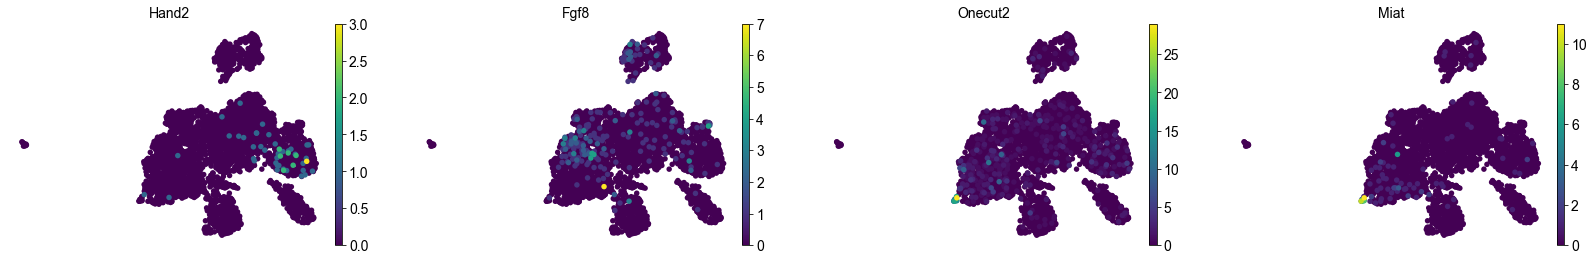

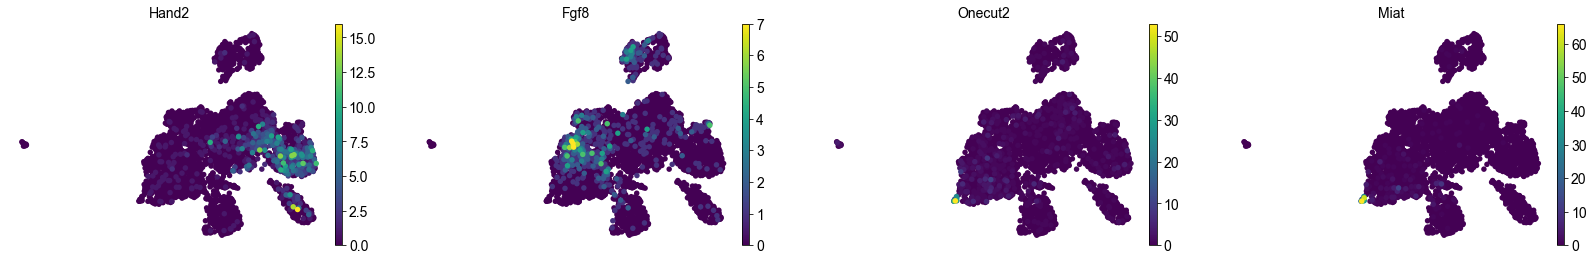

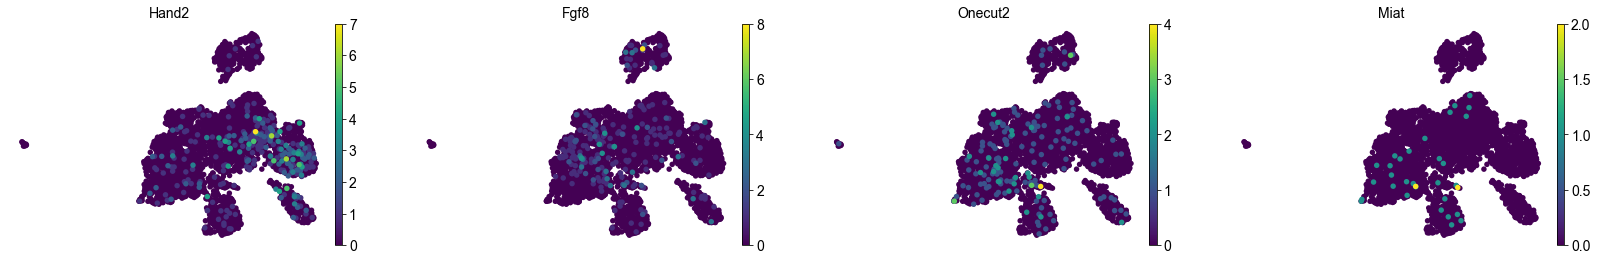

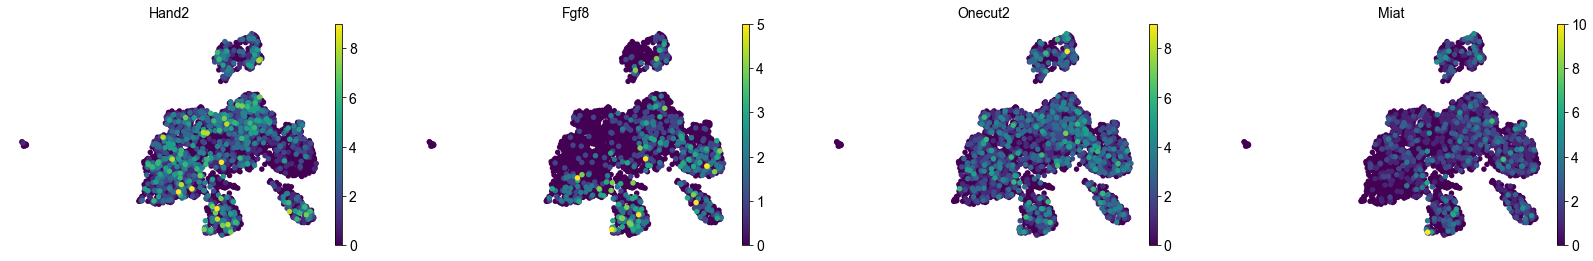

In [30]:
for layer in layers:
    sc.pl.umap(adata,color=["Hand2","Fgf8", "Onecut2","Miat"], size = 120,layer=layer, frameon=False)
    


Save dataframe with added chic layers:

In [31]:
adata

AnnData object with n_obs × n_vars = 4396 × 27312
    obs: 'n_counts', 'n_genes', 'percent_mito', 'batch', 'day', 'replicates', 'mark', 'umap_density_mark', 'leiden', 'louvain', 'celltype', 'cellnames', 'bc', 'cellname'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'celltype_colors', 'day_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'mark_colors', 'neighbors', 'pca', 'rank_genes_groups', 'replicates_colors', 'umap', 'umap_density_mark_params'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'k27_raw', 'k4_raw'
    obsp: 'connectivities', 'distances'

In [32]:
results_file = pathToData + '/dataframes/20210304_TCHIC_rep2_adata_trans_chic.h5ad' 
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading